In [ ]:
'''
Statistical and Machine Learning Methods in Particle and Astrophysics
TUM - summer term 2019
M. Agostini <matteo.agostini@tum.de> and Hans Niederhausen@tum.de <hans.niederhausen@tum.de>

snippet: "concept of coverage using the normal mean as example"

Here we demonstrate the concept of coverage (see lecture) of a confidence interval using the example
of estimating the mean of a normal distribution.

We assume that the variance is a known constant (not an unknown parameter).
Thus, the normal mean is the only parameter in this problem.

To construct the confidence interval we use the pivotal quantity (\bar{x}-mu)/(sigma/sqrt(N)).
(in this problem this is equivalent to the corresponding likelihood ratio hypothesis test)
'''



In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use('ggplot')


def normal_conf_int_pivot(X, sigma=1., n=10, coverage=0.683):
    '''
    definition of the confidence interval.
    calculates lower and upper end of interval.
    
    X: samples from normal distribution
    sigma: constant (known) value of std deviation
    n: number of samples
    coverage: desired probability that this interval will enclose the true value 
    
    satisfies P(lower(X) <= true_mean <= upper(X)) = coverage
    (independent of true value of gaussian mean)
    '''
    
    mean = np.mean(X)
    a = -norm.ppf((1.-coverage)/2, 0, 1)
    
    half_range = a * sigma / np.sqrt(n)
    lower = mean - half_range
    upper = mean + half_range
    return (lower, upper)    

(9.159906177672369, 10.425629098042577)


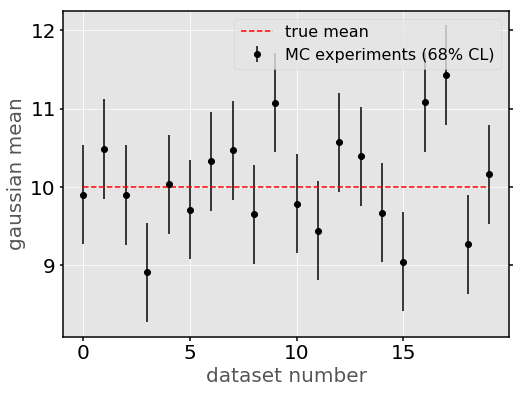

In [2]:
# Let's verify numerically that this works 
# Here we generate 20 experiments generated with the following properties:
sigma = 2.0 # known constant
n = 10 # sample size in each experiment
true_mean=10 # true mean realized in "nature"

# example usage
X = np.random.normal(10, sigma, n)
print normal_conf_int_pivot(X, sigma=sigma, n=n)

ndatasets = 20 # number of datasets to be generated, i.e. number of confidence intervals to be calculated

lower = []
upper = []
means = []

for k in range(ndatasets):
    # in each experiment we obtain the estimated mean and the corresponding confidence interval
    X = np.random.normal(true_mean, sigma, n)
    ll, uu = normal_conf_int_pivot(X, sigma=sigma, n=n)
    mean = np.mean(X)
    means.append(mean)
    lower.append(mean-ll)
    upper.append(uu-mean)
    
dataset_no = np.linspace(0,19, 20)

# plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.errorbar(dataset_no, means, yerr=[lower, upper], fmt='o', color='k', label="MC experiments (68% CL)")
ax.plot(dataset_no, np.ones(len(dataset_no))*true_mean, "r--", label="true mean") 

ax.set_xlabel('dataset number', fontsize=20)
ax.set_ylabel('gaussian mean', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
    
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
plt.legend(fontsize=16)

# in this ensemble of 20 experiments we find that 6 / 20 confidence intervals do not enclose the true mean 
# (red line) that was used to generate the data 
# this is consistent with a coverage of ~68% (6/20 = 0.3)

In [4]:
# we can now study the coverage as function of the true mean
# for different true values of the true mean, we generate an ensemble of 1000 experiments as above.
# the fraction of confidence intervals that enclose the true value is used to estimate the coverage of the interval

coverage = []
sigma = 2.0
n = 10
ndatasets = 1000
means = np.linspace(4,15,101)
for true_mean in means:
    in_interval = []
    for k in range(ndatasets):
        X = np.random.normal(true_mean, sigma, n)
        ll, uu = normal_conf_int_pivot(X, sigma=sigma, n=n)
        if true_mean < ll or true_mean > uu:
            in_interval.append(0)
        else:
            in_interval.append(1)
            
    in_interval = np.asarray(in_interval)
    idx_inside = np.where(in_interval>0.5)[0]
    tcov = len(in_interval[idx_inside])*1.0 / len(in_interval)
    coverage.append(tcov)

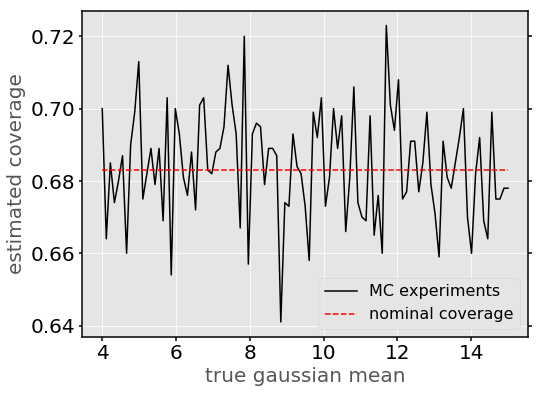

In [5]:
# plot estimated coverage as function of true mean

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.plot(means, coverage, color='k', label = "MC experiments")
plt.plot(means, np.ones(len(means))*0.683, "r--", label = "nominal coverage")

ax.set_xlabel('true gaussian mean', fontsize=20)
ax.set_ylabel('estimated coverage', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
    
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
plt.legend(fontsize=16)

# the MC experiments appear to be consistent with nominal coverage independent of the true value
# of the gaussian mean

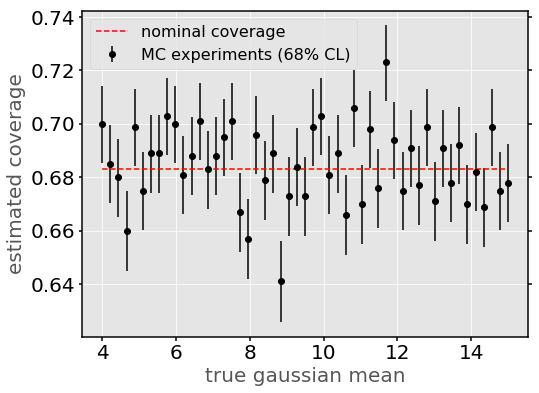

In [6]:
# the fluctuations in the above plot are due to the limited MC experiments. 
# it can be useful to give a confidence interval on the estimate coverage
# this is a binomial problem (we are asking for a range of probabilities that is consistent with our MC experiment)

# rather than constructing the intervals ourselves, we use a package for convenience

from statsmodels.stats.proportion import proportion_confint
coverage_err_low = []
coverage_err_high = []
for tcov in coverage:
    lower, upper = proportion_confint(int(tcov * ndatasets), ndatasets, alpha=0.32, method='jeffreys')
    coverage_err_low.append(tcov - lower)
    coverage_err_high.append(upper - tcov)

# plot only every second experiment. 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.errorbar(means[::2], coverage[::2], yerr=[coverage_err_low[::2], coverage_err_high[::2]], fmt='o', color='k', label="MC experiments (68% CL)")
plt.plot(means, np.ones(len(means))*0.683, "r--", label="nominal coverage")

ax.set_xlabel('true gaussian mean', fontsize=20)
ax.set_ylabel('estimated coverage', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
    
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
plt.legend(fontsize=16)

# the MC experiments appear consistent with the nominal coverage when uncertainties 
# due to finite MC size are taken into account